Here we will test parameter recovery and model comparison for Rescorla-Wagner (RW), Hierarchical Gaussian Filters (HGF), and Switching Gaussian Filters (SGF) models of the social influence task.

In [20]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

def posterior_accuracy(labels, df, vals, nsub):
    for i, lbl in enumerate(labels):
        std = df.loc[df['parameter'] == lbl].groupby(by='subject').std()
        mean = df.loc[df['parameter'] == lbl].groupby(by='subject').mean()
        print(lbl, np.sum(((mean+2*std).values[:, 0] > vals[i])*((mean-2*std).values[:, 0] < vals[i]))/(2*nsub))

Lets start by generating some behavioral data from the social influence task. Here green advice/choice is encoded as 0 and the blue advice/choice is encoded as 1.

In [71]:
import torch
from torch import ones, zeros, tensor

from pybefit.tasks import SocialInfluence
from pybefit.simulate import Simulator
from pybefit.inference import Horseshoe, Normal
from pybefit.agents import RLSocInf, HGFSocInf, SGFSocInf

torch.manual_seed(1234)

nsub = 50  # number of subjects
trials = 120  # number of trials/responses

# load stimuli (trial offers, advices, and reliability of advices)
reliability = torch.from_numpy(np.load('advice_reliability.npy')).float()
reliability = reliability.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)

offers = torch.from_numpy(np.load('offers.npy')).reshape(trials, -1, 1).repeat(1, 1, nsub)\
            .reshape(trials, -1).unsqueeze(0)

stimuli = {'offers': offers, 
           'reliability': reliability}

# RL agent
rl_agent = RLSocInf(runs=2*nsub, trials=trials)

trans_pars1 = torch.arange(-1., 1., 2./(2*nsub)).reshape(-1, 1) + tensor([[-2., 2., 2., 0.]]) 
rl_agent.set_parameters(trans_pars1)

# HGF agent
hgf_agent = HGFSocInf(runs=2*nsub, trials=trials)

trans_pars2 = torch.arange(-1., 1., 2./(2*nsub)).reshape(-1, 1) + tensor([[0., 0., 2., 2., 0.]]) 
hgf_agent.set_parameters(trans_pars2)

# SGF agent
sgf_agent = SGFSocInf(runs=2*nsub, trials=trials)

trans_pars3 = torch.arange(-1., 1., 2./(2*nsub)).reshape(-1, 1) + tensor([[-1., 0., 2., 2., 0.]])
sgf_agent.set_parameters(trans_pars3)

# simulate behaviour

sim = Simulator([SocialInfluence(stimuli, nsub=nsub), SocialInfluence(stimuli, nsub=nsub), SocialInfluence(stimuli, nsub=nsub)], [rl_agent, hgf_agent, sgf_agent], trials=trials)
sim.simulate_experiment();

stimuli, responses = sim.format_stimuli_and_responses()

plot performance of different agents in different blocks

RL agent:  [0.60833335 0.65      ]
HGF agent:  [0.60833335 0.65      ]
SGF agent:  [0.65 0.65]


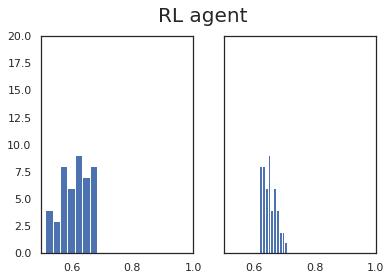

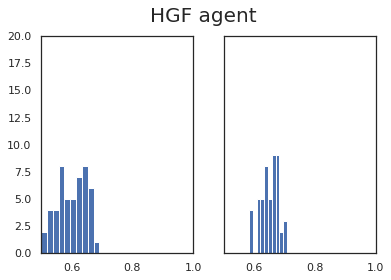

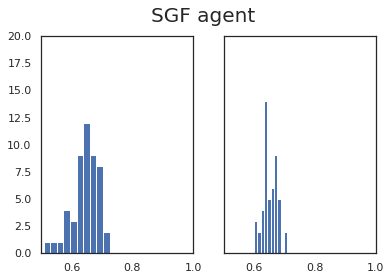

In [72]:
def compute_mean_performance(outcomes, responses):
    cc1 = (outcomes * responses > 0.).float()  # accept reliable offer
    cc2 = (outcomes * (1 - responses) < 0.).float() # reject unreliable offer
    
    return torch.einsum('ijk->k', cc1 + cc2)/trials

perf1 = compute_mean_performance(stimuli['pair_0']['outcomes'][..., 0].float(),
                                 responses['pair_0'].float()).numpy().reshape(2, -1) 

print('RL agent: ', np.median(perf1, axis = -1))

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].hist(perf1[0]);
ax[1].hist(perf1[1]);
fig.suptitle('RL agent', fontsize = 20);
ax[0].set_ylim([0, 20]);
ax[0].set_xlim([.5, 1.]);

perf2 = compute_mean_performance(stimuli['pair_1']['outcomes'][..., 0].float(),
                                 responses['pair_1'].float()).numpy().reshape(2, -1)
print('HGF agent: ', np.median(perf2, axis = -1))

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].hist(perf2[0]);
ax[1].hist(perf2[1]);
fig.suptitle('HGF agent', fontsize = 20);
ax[0].set_ylim([0, 20]);
ax[0].set_xlim([.5, 1.]);

perf3 = compute_mean_performance(stimuli['pair_2']['outcomes'][..., 0].float(),
                                 responses['pair_2'].float()).numpy().reshape(2, -1)
print('SGF agent: ', np.median(perf3, axis = -1))

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].hist(perf3[0]);
ax[1].hist(perf3[1]);
fig.suptitle('SGF agent', fontsize = 20);
ax[0].set_ylim([0, 20]);
ax[0].set_xlim([.5, 1.]);

Fit simulated behavior

In [53]:
num_samples = 1000
stimulus = stimuli['pair_0']
stimulus['mask'] = torch.ones(1, 120, 100)

rl_infer = Horseshoe(rl_agent, stimulus, responses['pair_0'])
rl_infer.infer_posterior(iter_steps=2000)

var_names = ['alpha', 'zeta', 'beta', 'bias']
tp_df = rl_infer.sample_posterior(var_names, num_samples=num_samples)

Mean ELBO 4178.42: 100%|█████████████████████| 2000/2000 [07:10<00:00,  4.65it/s]


Compute fit quality and plot posterior estimates from a hierarchical parameteric model

In [54]:
labels = [r'$\alpha$', r'$\zeta$', r'$\beta$', r'$\theta$']
trans_pars_rl = tp_df[0].melt(id_vars='subject', var_name='parameter')

vals = [trans_pars1[:,0].numpy(), trans_pars1[:, 1].numpy(), trans_pars1[:, 2].numpy(), trans_pars1[:, 3].numpy()]
posterior_accuracy(var_names, trans_pars_rl, vals, nsub)

alpha 0.97
zeta 0.94
beta 1.0
bias 0.93


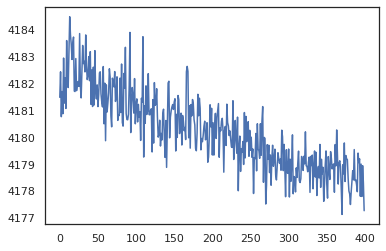

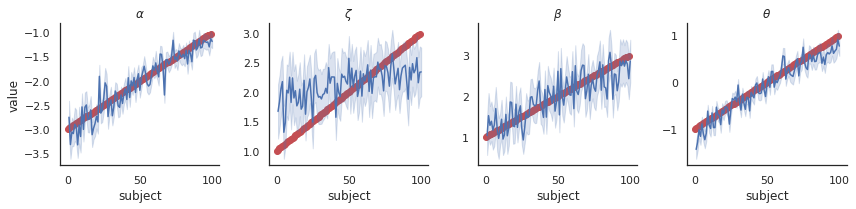

In [55]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(rl_infer.loss[-400:])

g = sns.FacetGrid(trans_pars_rl, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

labels = [r'$\alpha$', r'$\zeta$', r'$\beta$', r'$\theta$']
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2*nsub), trans_pars1[:, i].numpy(),'ro', zorder = 0);
    g.axes[0, i].set_title(labels[i])

fit HGF agent to simulated data

In [68]:
num_samples = 1000
stimulus = stimuli['pair_1']
stimulus['mask'] = torch.ones(1, 120, 100)

hgf_infer = Horseshoe(hgf_agent, stimulus, responses['pair_1'])
hgf_infer.infer_posterior(iter_steps=2000)

var_names = ['mu0_2', 'eta', 'zeta', 'beta', 'bias']
hgf_tp_df = hgf_infer.sample_posterior(var_names, num_samples=num_samples)

Mean ELBO 4773.85: 100%|█████████████████████| 2000/2000 [13:14<00:00,  2.52it/s]


In [67]:
trans_pars_hgf = hgf_tp_df[0].melt(id_vars='subject', var_name='parameter')

vals = [trans_pars2[:, i].numpy() for i in range(len(var_names))]
posterior_accuracy(var_names, trans_pars_hgf, vals, nsub)

mu0_2 0.73
eta 1.0
zeta 0.89
beta 0.89
bias 0.96


Plot posterior estimates from simulated data for the HGF agent

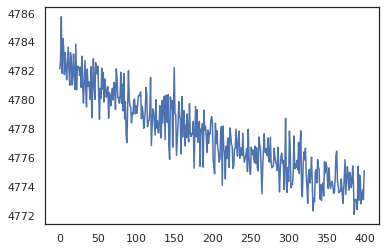

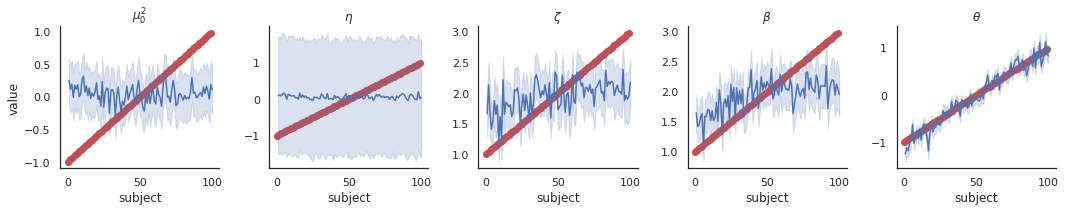

In [69]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(hgf_infer.loss[-400:])

g = sns.FacetGrid(trans_pars_hgf, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

labels = [r'$\mu_0^2$', r'$\eta$', r'$\zeta$', r'$\beta$', r'$\theta$']
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2*nsub), trans_pars2[:,i].numpy(),'ro', zorder = 0);
    g.axes[0, i].set_title(labels[i])

In [73]:
stimulus = stimuli['pair_2']
stimulus['mask'] = torch.ones(1, 120, 100)

sgf_infer = Horseshoe(sgf_agent, stimulus, responses['pair_2'])
sgf_infer.infer_posterior(iter_steps=2000)

var_names = ['rho1', 'h',  'zeta', 'beta', 'bias']
sgf_tp_df = sgf_infer.sample_posterior(var_names, num_samples=num_samples)

Mean ELBO 3608.09: 100%|█████████████████████| 2000/2000 [13:24<00:00,  2.49it/s]


In [74]:
trans_pars_sgf = sgf_tp_df[0].melt(id_vars='subject', var_name='parameter')

vals = [trans_pars3[:, i].numpy() for i in range(len(var_names))]
posterior_accuracy(var_names, trans_pars_sgf, vals, nsub)

rho1 0.94
h 0.97
zeta 0.85
beta 0.96
bias 0.96


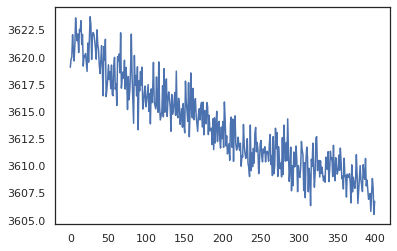

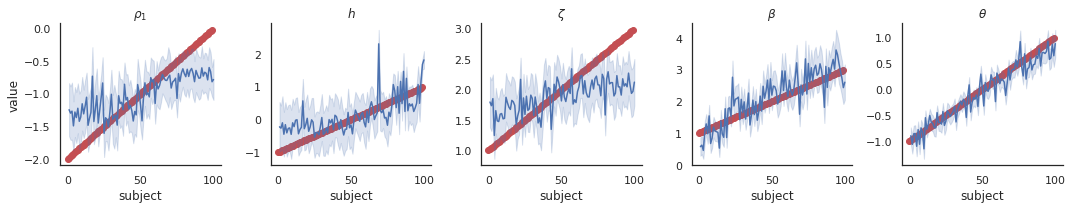

In [75]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(sgf_infer.loss[-400:])

g = sns.FacetGrid(trans_pars_sgf, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

labels = [r'$\rho_1$', r'$h$',  r'$\zeta$', r'$\beta$', r'$\theta$']
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars3[:, i].numpy(), 'ro', zorder=0);
    g.axes[0, i].set_title(labels[i])

Test model comparison

In [81]:
for i in range(3):
    stimuli['pair_{}'.format(i)].update({'mask': torch.ones(1, 120, 100)})

rl_infer = [Horseshoe(rl_agent, stimuli['pair_0'], responses['pair_0']),
            Horseshoe(rl_agent, stimuli['pair_1'], responses['pair_1']),
            Horseshoe(rl_agent, stimuli['pair_2'], responses['pair_2'])]

evidences = torch.zeros(3, 3, 2 * nsub)
for i in range(3):
    rl_infer[i].infer_posterior(iter_steps=1000)
    evidences[0, i] = rl_infer[i].get_log_evidence_per_subject()
    
hgf_infer = [Horseshoe(hgf_agent, stimuli['pair_0'], responses['pair_0']),
             Horseshoe(hgf_agent, stimuli['pair_1'], responses['pair_1']),
             Horseshoe(hgf_agent, stimuli['pair_2'], responses['pair_2'])]

for i in range(3):
    hgf_infer[i].infer_posterior(iter_steps=1000)
    evidences[1, i] = hgf_infer[i].get_log_evidence_per_subject()
    
sgf_infer = [Horseshoe(sgf_agent, stimuli['pair_0'], responses['pair_0']),
             Horseshoe(sgf_agent, stimuli['pair_1'], responses['pair_1']),
             Horseshoe(sgf_agent, stimuli['pair_2'], responses['pair_2'])]

for i in range(3):
    sgf_infer[i].infer_posterior(iter_steps=1000)
    evidences[2, i] = sgf_infer[i].get_log_evidence_per_subject()

Mean ELBO 3705.91: 100%|█████████████████████| 1000/1000 [06:53<00:00,  2.42it/s]


In [82]:
print((evidences[:, 0].argmax(dim=0) == 0).sum().float()/(2*nsub))
print((evidences[:, 1].argmax(dim=0) == 1).sum().float()/(2*nsub))
print((evidences[:, 2].argmax(dim=0) == 2).sum().float()/(2*nsub))
evidences.sum(-1)

tensor(0.6800)
tensor(0.3300)
tensor(0.4500)


tensor([[-4197.6558, -4809.9990, -3716.1531],
        [-4232.6968, -4810.6689, -3996.1685],
        [-4295.4995, -4861.0249, -3701.2620]])

The diagonal elements in the above matrix are not always the lowest values for the corresponding column, which shows that we cannot accuretly infer the correct model over population, and probably not per subject. More detailed analysis of the possible parameteric models is required.